# Data Engineering: Staging_to_Curated


#### Moving the data from the Staging to the Curated Zone
Curated zone is the final point where data is loaded and it feeds the data to the Dashboard or AL/ML models.
So, all feature engineering and relevant data manipulations would be done here before loading the data to the Curated zone.

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType, ArrayType

##### We have run the Notebook many times to get the final outputs, it is wise to drop the curated database before rerunning to avoid errors. 

In [ ]:
%sql 
-- This cell will remove everything from the staging database 
DROP DATABASE IF EXISTS curated CASCADE;

In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

#### Checking the tables created in the Staging Zone, to be used here.

In [ ]:
%sql
USE staging;
SHOW TABLES;

database,tableName,isTemporary
staging,customers,false
staging,orders,false


#### Checking the table layout as on Staging zone.

In [ ]:
%sql
describe formatted staging.orders;

col_name,data_type,comment
Index,int,null
Order_Id,int,null
Order_Date,date,null
Item_Id,string,null
Qty_Ordered,int,null
Price,string,null
Value,string,null
Discount_Amount,string,null
Total,string,null
Category,string,null


#### Checking if the Orders table have any versions, we will use the latest version.

In [ ]:
%fs ls dbfs:/user/hive/warehouse/staging.db/orders

path,name,size,modificationTime
dbfs:/user/hive/warehouse/staging.db/orders/Year_Month=2020-10/,Year_Month=2020-10/,0,0
dbfs:/user/hive/warehouse/staging.db/orders/Year_Month=2020-11/,Year_Month=2020-11/,0,0
dbfs:/user/hive/warehouse/staging.db/orders/Year_Month=2020-12/,Year_Month=2020-12/,0,0
dbfs:/user/hive/warehouse/staging.db/orders/Year_Month=2021-01/,Year_Month=2021-01/,0,0
dbfs:/user/hive/warehouse/staging.db/orders/Year_Month=2021-02/,Year_Month=2021-02/,0,0
dbfs:/user/hive/warehouse/staging.db/orders/Year_Month=2021-03/,Year_Month=2021-03/,0,0
dbfs:/user/hive/warehouse/staging.db/orders/Year_Month=2021-04/,Year_Month=2021-04/,0,0
dbfs:/user/hive/warehouse/staging.db/orders/Year_Month=2021-05/,Year_Month=2021-05/,0,0
dbfs:/user/hive/warehouse/staging.db/orders/Year_Month=2021-06/,Year_Month=2021-06/,0,0
dbfs:/user/hive/warehouse/staging.db/orders/Year_Month=2021-07/,Year_Month=2021-07/,0,0


### Curated Zone
Creating the database, curated here.

In [ ]:
%sql 
DROP DATABASE IF EXISTS curated CASCADE;

CREATE DATABASE curated; 

#### Read staging tables

In [ ]:
orders_df = spark.read.table("staging.orders")
orders_df.cache()
## cache the DF to hold the data in memory

cust_df = spark.read.table("staging.customers")
cust_df.cache()
## cache the DF to hold the data in memory

Out[56]: DataFrame[City: string, County: string, Customer_Since: date, E_Mail: string, Gender: string, Place_Name: string, Region: string, State: string, ZIP: int, Age: int, Cust_Id: int, Full_Name: string]

## Defining pipelines

### 1. Management wants to drill down the order volume and revenue generated by year, month, categories

In [ ]:
order_volume_and_revenue = (orders_df
                            .groupBy( "Year_Month", "Category")
                            .agg( sum("Qty_Ordered").alias("Total_Orders"), 
                                  sum("Total").alias("Total_Revenue")))

##### GroupBy function will help to get the data segregated bby year, month and Category while the aggregate function will get the Total Orders (volume) and Total Revenue

In [ ]:
order_volume_and_revenue.show(5)

+----------+------------------+------------+--------------------+
|Year_Month|          Category|Total_Orders|       Total_Revenue|
+----------+------------------+------------+--------------------+
|   2021-04|            Others|       70443|1.2136769999999998E7|
|   2020-12|        Superstore|        7015|  295431.22933999944|
|   2020-12|             Books|         291|   2888.979180000001|
|   2021-04|School & Education|         935|   23724.20000000002|
|   2021-04|   Health & Sports|        4303|  142003.09000000008|
+----------+------------------+------------+--------------------+
only showing top 5 rows



##### Storing the created data into a table on the Curated zone/ curated database.

In [ ]:
order_volume_and_revenue.write.saveAsTable("curated.ordervolandrevenue")

### 2. Revenue growth by categories from previous month to this month.

In [ ]:
# Convert Order_Date to Year-Month format and group by Category and Month
revenue_by_category_df = (orders_df.withColumn("Year-Month", date_format(col("Order_Date"), "yyyy-MM"))
                          .groupBy("Category", "Year-Month")
                          .agg(sum("Total").alias("Total_Revenue")))
revenue_by_category_df.show(5)

+-----------------+----------+--------------------+
|         Category|Year-Month|       Total_Revenue|
+-----------------+----------+--------------------+
|       Appliances|   2020-12|   9381459.439649912|
|  Health & Sports|   2021-04|  142003.09000000008|
|          Soghaat|   2020-12|   50151.83834000017|
|       Superstore|   2021-04|   299981.4589999996|
|Mobiles & Tablets|   2020-12|3.2280553189050723E7|
+-----------------+----------+--------------------+
only showing top 5 rows



In [ ]:
# Define a window specification partitioned by Category and ordered by Year-Month
window_spec = Window.partitionBy("Category").orderBy("Year-Month")

# Calculate the previous month's revenue using the lag function
revenue_by_category_df = revenue_by_category_df.withColumn("Previous_Revenue", lag("Total_Revenue").over(window_spec))

# Calculate the revenue growth as a percentage
revenue_by_category_df = revenue_by_category_df.withColumn("Revenue_Growth", 
                                   expr("((Total_Revenue - Previous_Revenue) / Previous_Revenue) * 100"))

##### Here, we are creating a window with category and year-month to suit the purpose. 
##### The Lag function helps to get get the revenue for the category from the window created.

In [ ]:
revenue_by_category_df.show(5)

+----------+----------+-----------------+-----------------+-------------------+
|  Category|Year-Month|    Total_Revenue| Previous_Revenue|     Revenue_Growth|
+----------+----------+-----------------+-----------------+-------------------+
|Appliances|   2020-10|420055.8982799999|             null|               null|
|Appliances|   2020-11|451277.5483700002|420055.8982799999|  7.432736980445551|
|Appliances|   2020-12|9381459.439649912|451277.5483700002| 1978.8668688560815|
|Appliances|   2021-01|1113173.024400007|9381459.439649912| -88.13432993490032|
|Appliances|   2021-02|731731.0170000022|1113173.024400007|-34.266192140759024|
+----------+----------+-----------------+-----------------+-------------------+
only showing top 5 rows



##### Storing the created data into a table on the Curated zone/ curated database.

In [ ]:
revenue_by_category_df.write.saveAsTable("curated.revenuebycategory")

### 3. Top 5 categories having a maximum number of orders and maximum number of cancellations in the month.

In [ ]:
category_by_orders_df = (orders_df.groupBy("Year_Month", "Category")
                        .agg(
                            count("Order_Id").alias("Total_Order"),
                            count(when(col("Final_Status") == "cancelled", True)).alias("Total_Cancellations")
                            ))
                        
category_by_orders_df.show(5)

+----------+------------------+-----------+-------------------+
|Year_Month|          Category|Total_Order|Total_Cancellations|
+----------+------------------+-----------+-------------------+
|   2021-04|            Others|      17365|              11924|
|   2020-12|        Superstore|       2106|                741|
|   2020-12|             Books|        112|                 23|
|   2021-04|School & Education|        152|                 76|
|   2021-04|   Health & Sports|       1007|                139|
+----------+------------------+-----------+-------------------+
only showing top 5 rows



##### Storing the created data into a table on the Curated zone/ curated database.

In [ ]:
category_by_orders_df.write.saveAsTable("curated.categorybyorders")

### 4. Segment customers by age: 0-20 as young, 20-35 adults, 35-55 middle-ages and >55 Old. Find the total spend (in percentage of total spend of categories) by customers by different age segments by different categories until this month i.e. including all previous and current month.

To get the spend, we have considered the orders that have not been cancelled, since any order that has been canceled would mean that the product was not delivered and no revenue was generated against it.

In [ ]:
select_df = orders_df.filter(col("Final_Status") != "Cancelled")
select_df.show(5)

# Join cust_df and orders_df on Customer_ID, selecting specific columns
select_df = (select_df.join(cust_df, on="Cust_Id")
               .select("Order_Id", "Category", "Cust_Id", "Age", "Total"))
select_df.show(5)

+-----+---------+----------+-------+-----------+-----+-----+---------------+---------+-------------+--------------+-------+------------+----------+
|Index| Order_Id|Order_Date|Item_Id|Qty_Ordered|Price|Value|Discount_Amount|    Total|     Category|Payment_Method|Cust_Id|Final_Status|Year_Month|
+-----+---------+----------+-------+-----------+-----+-----+---------------+---------+-------------+--------------+-------+------------+----------+
|   12|100403034|2020-12-24| 656937|          2|254.8|254.8|       39.80628|214.99372|   Appliances|       Easypay|  42485|   cancelled|   2020-12|
|   13|100403034|2020-12-24| 656938|          2|315.5|315.5|       49.28917|266.21083|   Appliances|       Easypay|  42485|   cancelled|   2020-12|
|   14|100403034|2020-12-24| 656939|          2| 69.8| 69.8|       10.90455| 58.89545|Home & Living|       Easypay|  42485|   cancelled|   2020-12|
|   15|100403077|2020-12-24| 657023|          2|254.8|254.8|       39.80628|214.99372|   Appliances|       Easyp

##### Creating the Age segmentations as per specifications.

In [ ]:
select_df = select_df.withColumn("Age_Segment",
                                 when(col("Age") <= 20, "Young")
                                .when((col("Age") > 20) & (col("Age") <= 35), "Adult")
                                .when((col("Age") > 35) & (col("Age") <= 55), "Middle-aged")
                                .otherwise("Old")
                                )
select_df.show(5)

+---------+-------------+-------+---+---------+-----------+
| Order_Id|     Category|Cust_Id|Age|    Total|Age_Segment|
+---------+-------------+-------+---+---------+-----------+
|100403034|   Appliances|  42485| 28|214.99372|      Adult|
|100403034|   Appliances|  42485| 28|266.21083|      Adult|
|100403034|Home & Living|  42485| 28| 58.89545|      Adult|
|100403077|   Appliances|  42485| 28|214.99372|      Adult|
|100403077|   Appliances|  42485| 28|266.21083|      Adult|
+---------+-------------+-------+---+---------+-----------+
only showing top 5 rows



In [ ]:
spend_by_age_df = (select_df.groupBy("Age_Segment", "Category")
                  .agg(sum("Total").alias("Total_Spend")))
spend_by_age_df.show(10)

+-----------+-----------------+-------------------+
|Age_Segment|         Category|        Total_Spend|
+-----------+-----------------+-------------------+
|      Young|        Computing| 392317.27405999997|
|        Old|  Women's Fashion| 2210364.8580900077|
|Middle-aged|  Women's Fashion|  2237083.183640005|
|Middle-aged|        Computing| 3695487.4124700027|
|      Adult|          Soghaat|       124999.26629|
|        Old|Beauty & Grooming|  926114.0865599976|
|      Adult|  Women's Fashion| 1713315.6540400009|
|Middle-aged|            Books| 10716.025000000003|
|        Old|Mobiles & Tablets|4.397622542092007E7|
|      Young|  Health & Sports| 32901.623329999995|
+-----------+-----------------+-------------------+
only showing top 10 rows



In [ ]:
# Calculate Spend as a Percentage of Total Spend per Category
category_total_df = spend_by_age_df.groupBy("Category").agg(sum("Total_Spend").alias("Category_Total_Spend"))

# Join the DataFrames to calculate the percentage spend
spend_by_age_df = spend_by_age_df.join(category_total_df, on="Category")
spend_by_age_df = spend_by_age_df.withColumn("Spend_Percentage", 
                                             round((col("Total_Spend") / col("Category_Total_Spend")) * 100,3))

# Display the Final Dataframe
spend_by_age_df.select("Age_Segment", "Category", "Spend_Percentage").show()

+-----------+------------------+----------------+
|Age_Segment|          Category|Spend_Percentage|
+-----------+------------------+----------------+
|        Old|School & Education|          26.682|
|Middle-aged|School & Education|          27.041|
|      Young|School & Education|           5.164|
|      Adult|School & Education|          41.114|
|        Old|     Entertainment|          33.327|
|      Adult|     Entertainment|          26.494|
|      Young|     Entertainment|           4.242|
|Middle-aged|     Entertainment|          35.937|
|      Adult|       Kids & Baby|          25.911|
|Middle-aged|       Kids & Baby|           31.44|
|        Old|       Kids & Baby|          35.417|
|      Young|       Kids & Baby|           7.232|
|        Old|         Computing|          30.236|
|      Adult|         Computing|          26.102|
|Middle-aged|         Computing|          39.472|
|      Young|         Computing|            4.19|
|      Young| Mobiles & Tablets|           4.911|


##### Storing the created data into a table on the Curated zone/ curated database.

In [ ]:
spend_by_age_df.write.saveAsTable("curated.spendbyage")

### 5. Calculate the RFM values for each customer (by customer id).
For Recency calculation, used "01/10/2021" as last date. 
So, the recency for any customer should be how many weeks before he or she has made the last purchase from the date of 01/10/2021.

In [ ]:
cutoff_date = to_date(lit("2021-10-01"), "yyyy-MM-dd")

# Calculate Recency

# Find the most recent order date per customer
recency_df = (orders_df.groupBy("Cust_Id")
              .agg(max("Order_Date").alias("Most_Recent_Purchase")))

# Calculate recency as the number of weeks since the most recent purchase
recency_df = recency_df.withColumn("Recency",
                                   round(datediff(cutoff_date, col("Most_Recent_Purchase"))/7,0))

In [ ]:
# Calculate Frequency

frequency_df = (orders_df.groupBy("Cust_Id")
                .agg(countDistinct("Order_Id").alias("Frequency")))


In [ ]:
# Calculate Monetary

# Filter out cancelled orders
non_cancelled_orders_df = orders_df.filter(col("Final_Status") != "cancelled")

monetary_df = (non_cancelled_orders_df.groupBy("Cust_Id")
               .agg(round(sum("Total"),2).alias("Monetary")))   
   

#### Joining the 3 Dataframes to create the Recency-Frequency-Monetary (RFM)

In [ ]:
# Combine RFM metrics into a single DataFrame
RFM_df = (recency_df.join(frequency_df, on="Cust_Id")
          .join(monetary_df, on="Cust_Id"))    

RFM_df.show(5)  

+-------+--------------------+-------+---------+--------+
|Cust_Id|Most_Recent_Purchase|Recency|Frequency|Monetary|
+-------+--------------------+-------+---------+--------+
|   8592|          2021-06-10|   16.0|        5|  1125.0|
|  42468|          2021-02-09|   33.0|       18|  3938.5|
|   7982|          2021-09-12|    3.0|        6| 1148.48|
|  18911|          2021-09-19|    2.0|       20| 8523.22|
|  63574|          2021-05-21|   19.0|        4| 1220.63|
+-------+--------------------+-------+---------+--------+
only showing top 5 rows



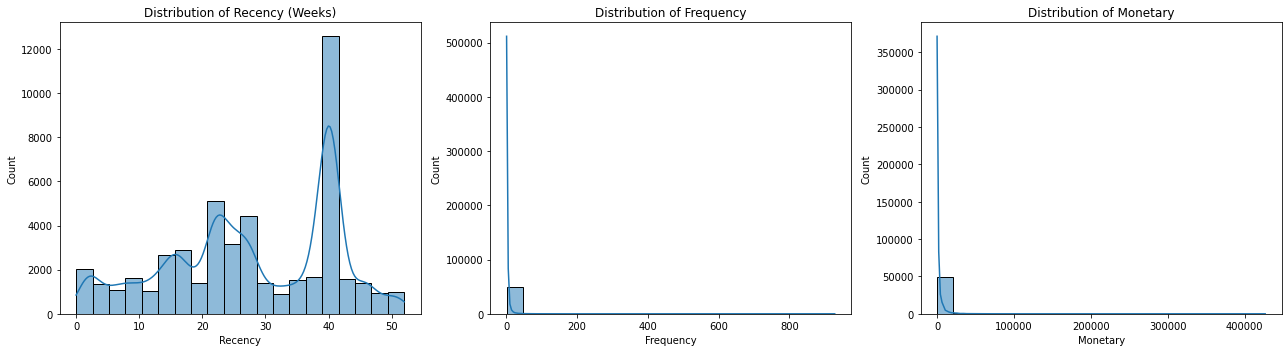

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame
rfm_pd_df = RFM_df.toPandas()

# Plot distribution of Recency, Frequency, and Monetary
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution of Recency
sns.histplot(rfm_pd_df["Recency"], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Recency (Weeks)')

# Distribution of Frequency
sns.histplot(rfm_pd_df["Frequency"], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Frequency')

# Distribution of Monetary
sns.histplot(rfm_pd_df["Monetary"], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Monetary')

plt.tight_layout()
plt.show()


#### Wanted to bin the RFM into Low, Mid and High. So, visualization to see the split was important.

In [ ]:
RFM_df = RFM_df.withColumn("Recency_Segment",
                             when(col("Recency") <= 15, "High")
                            .when((col("Recency") > 15) & (col("Recency") <= 30), "Mid")
                            .when(col("Recency") > 30, "Low"))

RFM_df = RFM_df.withColumn("Freq_Segment",
                             when(col("Frequency") <= 10, "Low")
                            .when((col("Frequency") > 10) & (col("Frequency") <= 50), "Mid")
                            .when(col("Frequency") > 50, "High"))

RFM_df = RFM_df.withColumn("Money_Segment",
                            when(col("Monetary") <= 5000, "Low")
                            .when((col("Monetary") > 5000) & (col("Monetary") <= 50), "Mid")
                            .when(col("Monetary") > 50, "High"))

In [ ]:
RFM_df.show(5)

+-------+--------------------+-------+---------+--------+---------------+------------+-------------+
|Cust_Id|Most_Recent_Purchase|Recency|Frequency|Monetary|Recency_Segment|Freq_Segment|Money_Segment|
+-------+--------------------+-------+---------+--------+---------------+------------+-------------+
|   8592|          2021-06-10|   16.0|        5|  1125.0|            Mid|         Low|          Low|
|  42468|          2021-02-09|   33.0|       18|  3938.5|            Low|         Mid|          Low|
|   7982|          2021-09-12|    3.0|        6| 1148.48|           High|         Low|          Low|
|  18911|          2021-09-19|    2.0|       20| 8523.22|           High|         Mid|         High|
|  63574|          2021-05-21|   19.0|        4| 1220.63|            Mid|         Low|          Low|
+-------+--------------------+-------+---------+--------+---------------+------------+-------------+
only showing top 5 rows



##### Storing the created data into a table on the Curated zone/ curated database.

In [ ]:
RFM_df.write.saveAsTable("curated.RFM")

### 6. Forecast revenue for each category based on simple exponential smoothing.

##### Simple Exponential Smoothing formula: Forecast(𝑡+1) = 𝛼 × Actual(𝑡) + (1 − 𝛼) × Forecast(𝑡)
Since we are deriving revenue, only considering the non-cancelled orders.

In [ ]:
# Define alpha for exponential smoothing
alpha = 0.6

# SES forecast function
def ses_forecast(revenue_list, alpha):
    forecasts = [revenue_list[0]]  # Initialize with the first actual value
    for i in range(1, len(revenue_list)):
        forecast = alpha * revenue_list[i-1] + (1 - alpha) * forecasts[i-1]
        forecasts.append(forecast)
    return forecasts

# UDF to apply SES forecast
ses_udf = udf(lambda revenues: ses_forecast(revenues, alpha), ArrayType(DoubleType()))

In [ ]:
# Filter out cancelled orders
non_cancelled_orders_df = (orders_df.filter(col("Final_Status") != "Cancelled")
                           .select("Category", "Year_Month", "Total"))

revenue_df = (non_cancelled_orders_df.groupBy("Category", "Year_Month")
              .agg(round(sum("Total"),2).alias("Revenue"))
              .orderBy("Category", "Year_Month"))

##### Creating a window with the revenuw of past 5 months to forecast using SES

In [ ]:
# Window specification to collect revenue data of past 5 months within each category 
window_spec = Window.partitionBy("Category").orderBy("Year_Month").rowsBetween(-4, 0)

# Collect revenue list and apply SES forecast
revenue_df = revenue_df.withColumn("Revenue_List", collect_list("Revenue").over(window_spec))
revenue_df = revenue_df.withColumn("Forecast_List", ses_udf("Revenue_List"))

# Assuming you want to forecast the next month, add a column for forecasted revenue
revenue_df = revenue_df.withColumn("Forecast_Revenue", col("Forecast_List")[4])

In [ ]:
# Display the results
revenue_df.show(5)

+----------+----------+----------+--------------------+--------------------+----------------+
|  Category|Year_Month|   Revenue|        Revenue_List|       Forecast_List|Forecast_Revenue|
+----------+----------+----------+--------------------+--------------------+----------------+
|Appliances|   2020-10|  420055.9|          [420055.9]|          [420055.9]|            null|
|Appliances|   2020-11| 451277.55|[420055.9, 451277...|[420055.9, 420055.9]|            null|
|Appliances|   2020-12|9381459.44|[420055.9, 451277...|[420055.9, 420055...|            null|
|Appliances|   2021-01|1113173.02|[420055.9, 451277...|[420055.9, 420055...|            null|
|Appliances|   2021-02| 731731.02|[420055.9, 451277...|[420055.9, 420055...|       2989660.3|
+----------+----------+----------+--------------------+--------------------+----------------+
only showing top 5 rows



##### Calculate the Forecast error

In [ ]:
# Calculate the difference and percentage error
revenue_df = revenue_df.withColumn("Error", col("Revenue") - col("Forecast_Revenue"))
revenue_df = revenue_df.withColumn("Percentage_Error", abs(col("Error")) / col("Revenue") * 100)

In [ ]:
# Display the results with errors
revenue_df.select("Category", "Year_Month", "Revenue", "Forecast_Revenue", "Error", "Percentage_Error").show(8)

+----------+----------+----------+------------------+-------------------+------------------+
|  Category|Year_Month|   Revenue|  Forecast_Revenue|              Error|  Percentage_Error|
+----------+----------+----------+------------------+-------------------+------------------+
|Appliances|   2020-10|  420055.9|              null|               null|              null|
|Appliances|   2020-11| 451277.55|              null|               null|              null|
|Appliances|   2020-12|9381459.44|              null|               null|              null|
|Appliances|   2021-01|1113173.02|              null|               null|              null|
|Appliances|   2021-02| 731731.02|         2989660.3|        -2257929.28| 308.5736723311251|
|Appliances|   2021-03|4895668.92|     1635702.00624|      3259966.91376| 66.58879444323208|
|Appliances|   2021-04|5038811.58|3820294.8108800002| 1218516.7691199998|24.182622226965666|
|Appliances|   2021-05|1450175.69|        4339736.74|-2889561.05000000

##### Storing the created data into a table on the Curated zone/ curated database.

In [ ]:
revenue_df.write.saveAsTable("curated.revenueforecast")

## Additional insights

### 7. Understanding the pattern among Payment method and Final status of orders

In [ ]:
# Aggregate counts of orders by status
status_counts_df = (orders_df.groupBy("Category", "Payment_Method", "Year_Month", "Final_Status")
                    .agg(count("Order_Id").alias("Order_Count"))
                    .orderBy("Category", "Payment_Method", "Year_Month"))

In [ ]:
# Show the aggregated data
status_counts_df.show(5)

+----------+--------------+----------+------------+-----------+
|  Category|Payment_Method|Year_Month|Final_Status|Order_Count|
+----------+--------------+----------+------------+-----------+
|Appliances|       Easypay|   2020-10|   cancelled|         28|
|Appliances|       Easypay|   2020-10|    received|         19|
|Appliances|       Easypay|   2020-11|    received|         49|
|Appliances|       Easypay|   2020-11|   cancelled|         93|
|Appliances|       Easypay|   2020-12|    received|       2567|
+----------+--------------+----------+------------+-----------+
only showing top 5 rows



##### Storing the created data into a table on the Curated zone/ curated database.

In [ ]:
status_counts_df.write.saveAsTable("curated.statuscount")

### 8. Understanding the Orders based by demography and gender

In [ ]:
# Join cust_df and orders_df on cust_id
combined_df = (cust_df.join(orders_df, on="Cust_Id")
               .select("Cust_Id", "Total", "Payment_Method", "Region", "State", "Gender"))

# Aggregate revenue by state, city, and payment gender
revenue_df = (combined_df.groupBy("Region", "State", "Gender")
                     .agg(round(sum("Total"),2).alias("total_Revenue"))
                     .orderBy("Region", "State", "Gender"))

In [ ]:
revenue_df.show(5)

+-------+-----+------+-------------+
| Region|State|Gender|total_Revenue|
+-------+-----+------+-------------+
|Midwest|   IA|     F|   3278726.41|
|Midwest|   IA|     M|   2975767.91|
|Midwest|   IL|     F|   4390591.26|
|Midwest|   IL|     M|   4716303.63|
|Midwest|   IN|     F|   2470668.59|
+-------+-----+------+-------------+
only showing top 5 rows



##### Storing the created data into a table on the Curated zone/ curated database.

In [ ]:
revenue_df.write.saveAsTable("curated.revbydemography")

#### Making sure that the tables have been created properly.

In [ ]:
%sql
USE curated;
SHOW TABLES;

database,tableName,isTemporary
curated,categorybyorders,false
curated,ordervolandrevenue,false
curated,revbydemography,false
curated,revenuebycategory,false
curated,revenueforecast,false
curated,rfm,false
curated,spendbyage,false
curated,statuscount,false
